Random forests are an example of an ensemble method, a method that relies on aggregating the results of an ensemble of simpler estimators.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learner built on decision trees.

Creating a decision tree:

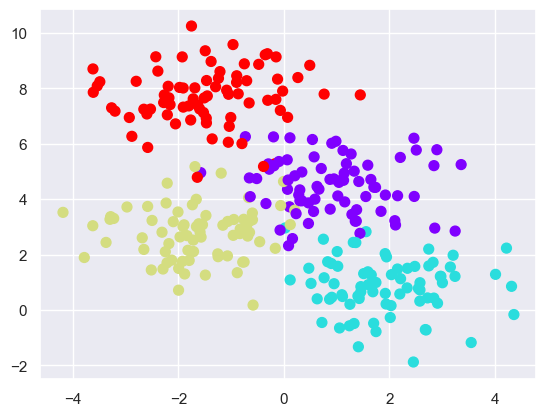

In [2]:
from sklearn.datasets import make_blobs
X , y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='rainbow')

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X,y)

Let's write a quick utility function to help us visulize the output of the classifier.

In [4]:
def visualize_classifier(model,X,y,ax=None,cmap='rainbow'):
    ax = ax or plt.gca()
    
    #Plot the training points
    ax.scatter(X[:,0],X[:,1],c=y,s=30,cmap=cmap,
              clim=(y.min(),y.max()),zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    #fit the estimator
    model.fit(X,y)
    xx, yy = np.meshgrid(np.linspace(*xlim,num=200),
                        np.linspace(*ylim,num=200))
    Z = model.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
    
    #Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx,yy,Z,alpha=0.3,
                          levels = np.arange(n_classes+1) - 0.5,
                          cmap=cmap,clim=(y.min(),y.max()),
                          zorder=1)
    ax.set(xlim=xlim,ylim=ylim)

In [5]:
visualize_classifier(DecisionTreeClassifier(),X,y)

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_1259/2168373717.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx,yy,Z,alpha=0.3,


Such Overfitting turns out to be a general property od decision trees; it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

# Ensembles of Estimators: Random Forests

This notion——that multiple overfitting estimators can be combined to reduce the effect of overfitting——is what underlies an ensemble method called bagging. Bagging makes use of an ensenble of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a random forests.

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_1259/2168373717.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx,yy,Z,alpha=0.3,


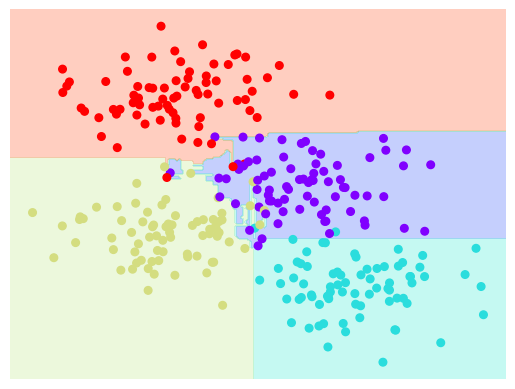

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree,n_estimators=100,max_samples=0.8,
                       random_state=1)

bag.fit(X,y)
visualize_classifier(bag,X,y)

In practice, decision trees are more effectively randomized when some stochasticity is injected in how the splits are chosen.

When determining which feature to split on, the randomized tree might select from among the top several features.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically.

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_1259/2168373717.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx,yy,Z,alpha=0.3,


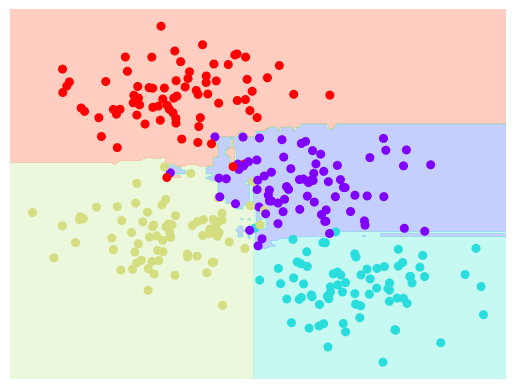

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,random_state=0)
visualize_classifier(model,X,y)

# Random Forest Regression

Consider the following data, drawn from the combonation of a fast and slow oscillation.

<ErrorbarContainer object of 3 artists>

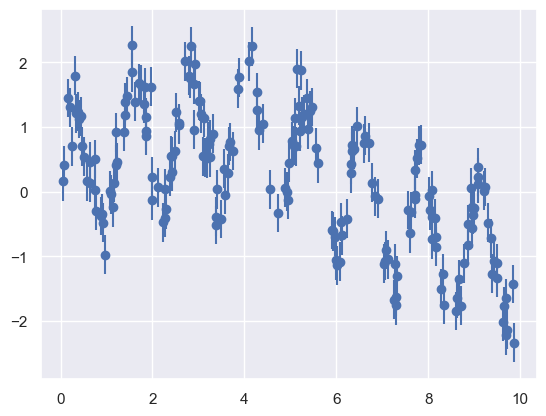

In [8]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x,sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x,y,0.3,fmt='o')

Using the random forest regressor, we can find the best-fit curve as follows:

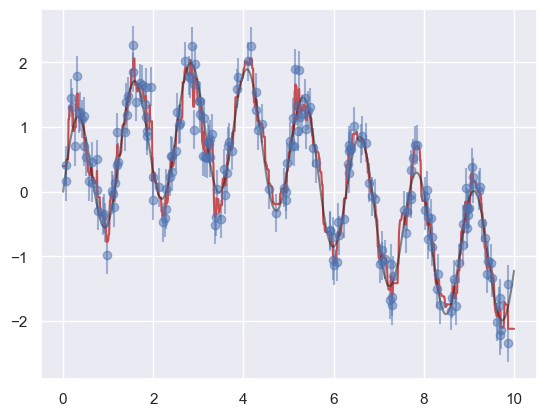

In [10]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:,None],y)

xfit = np.linspace(0,10,1000)
yfit = forest.predict(xfit[:,None])
ytrue = model(xfit,sigma=0)

plt.errorbar(x,y,0.3,fmt='o',alpha=0.5)
plt.plot(xfit,yfit,'-r')
plt.plot(xfit,ytrue,'-k',alpha=0.5)

Here the ture model is shown by the smooth curve, while the random forest forest model is shown by the jagged curve.

# Example: Random Forest for Classifying Digits

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

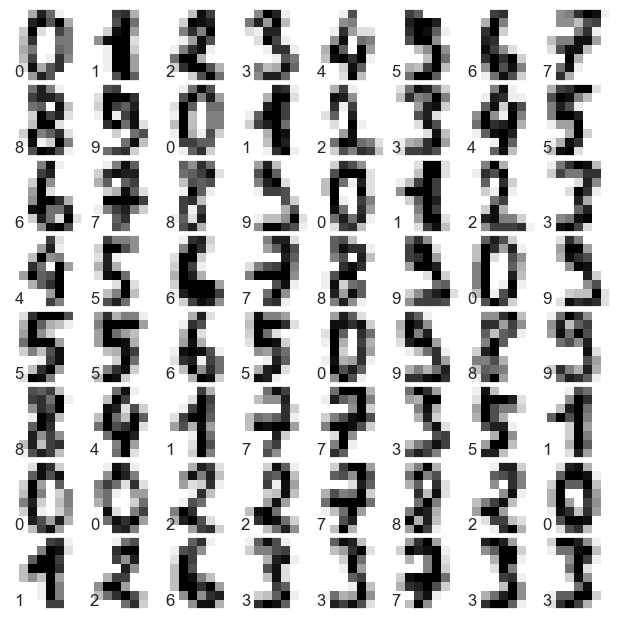

In [14]:
# set up the figure
fig = plt.figure(figsize=(6,6)) # figure size in inches
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)

# plot the digits: each image is 8*8 pixels
for i in range(64):
    ax = fig.add_subplot(8,8,i+1,xticks=[],yticks=[])
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
    
    #label the image with the target value
    ax.text(0,7,str(digits.target[i]))

We can quickly classify the digits using the random forest as follows:

In [20]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data,digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:

In [21]:
from sklearn import metrics
print(metrics.classification_report(ypred,ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

In [22]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest,ypred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Text(110.44999999999997, 0.5, 'predicted label')

# Summary of Random Forests

Advantages:
1. Both training and prediction can are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees can entirely independent entities.
2. The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method)
3. The nonparametric model is extremely flexible, and can thus perform well on tasks that are underfit by other estimators.

Disadvantage: the results are not easily interpretable.